In [85]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [86]:
# ! pip install optuna
# ! pip install xgboost

## Data loading
+ tt_data_for_ml -> traning data
+ tt_prerd_for_ml -> prediction layer
+ tt_congestion_to_hour -> MapCoefficient (To map the "t_travtime in training data the the continuous one")


Modify the input size to better balance between time cost and generalization

In [87]:
data = pd.read_csv("../data/tt_data_for_ml.csv")[:10000]
data = data.dropna()
data.head()

,id,t_travtime,lat_d,lon_d,lat_o,lon_o,od_dist,year,t_time_start,o_type_ageb,o_type_dist,d_type_ageb,d_type_dist,taxi,wt_tottrips,ageb_eod1990,t_distr_o,t_distr_d
0,1,40.0,19.378813,-99.119835,19.436481,-99.160004,7.732718,1994,1600.0,0,1,1,0,0,281.0,9007032,2,13
1,2,30.0,19.436481,-99.160004,19.378813,-99.119835,7.732718,1994,730.0,1,0,0,1,0,257.0,9007032,13,2
2,4,5.0,19.378813,-99.119835,19.376709,-99.117508,1.423484,1994,805.0,0,1,1,0,0,324.0,9007032,13,13
3,5,10.0,19.378813,-99.119835,19.376709,-99.117508,1.423484,1994,1350.0,0,1,1,0,0,498.0,9007032,13,13
4,7,60.0,19.355120,-99.067688,19.378813,-99.119835,6.098191,1994,700.0,1,0,0,1,0,319.0,9007032,13,39


In [103]:
pred_data = pd.read_csv("../data/tt_pred_for_ml.csv")
X_pred = pred_data[['lat_d', 'lon_d', 'lat_o', 'lon_o', 'od_dist', 'congested']]
pred_data.head()

,lat_d,lon_d,lat_o,lon_o,od_dist,year,congested,ageb_eod1990,t_o_distr,t_d_distr
0,19.436474,-99.132744,19.433231,-99.136597,1.308391,1994,0,NaN,1.0,1
1,19.436481,-99.160004,19.433231,-99.136597,2.871368,1994,0,NaN,1.0,2
2,19.447878,-99.136711,19.433231,-99.136597,1.923555,1994,0,NaN,1.0,3
3,19.438856,-99.116585,19.433231,-99.136597,2.610926,1994,0,NaN,1.0,4
4,19.443163,-99.103951,19.433231,-99.136597,3.723792,1994,0,NaN,1.0,5


In [89]:
MapCoefficient = pd.read_csv("../tt_congestion_to_hour.csv")
MapCoefficient.head()


,coef,time,year
0,0.112380,5,1994
1,0.154616,5,2007
2,0.172051,5,2017
3,0.081687,6,1994
4,0.181707,6,2007


Here I create a hashing dictionary to map the coef; The entry in the dict is in the form

**(TravelStartTime, Year): Coef**

In [90]:
Mapdict = {(i[1]['time'], i[1]["year"]): i[1]["coef"] for i in MapCoefficient.iterrows()}
Mapdict

{(5.0, 1994.0): 0.11237962,
 (5.0, 2007.0): 0.15461597,
 (5.0, 2017.0): 0.17205131,
 (6.0, 1994.0): 0.081686571,
 (6.0, 2007.0): 0.18170676,
 (6.0, 2017.0): 0.25248474,
 (7.0, 1994.0): 0.1258698,
 (7.0, 2007.0): 0.21459974,
 (7.0, 2017.0): 0.27214903,
 (8.0, 1994.0): 0.1748004,
 (8.0, 2007.0): 0.21649699,
 (8.0, 2017.0): 0.22586481,
 (9.0, 1994.0): 0.092247531,
 (9.0, 2007.0): 0.17791201,
 (9.0, 2017.0): 0.18731254,
 (10.0, 1994.0): 0.08799626699999999,
 (10.0, 2007.0): 0.172034,
 (10.0, 2017.0): 0.18067604,
 (11.0, 1994.0): 0.08964082599999999,
 (11.0, 2007.0): 0.17245339999999998,
 (11.0, 2017.0): 0.16176319,
 (12.0, 1994.0): 0.057175782,
 (12.0, 2007.0): 0.15652506,
 (12.0, 2017.0): 0.17911191,
 (13.0, 1994.0): 0.16353172,
 (13.0, 2007.0): 0.19154526,
 (13.0, 2017.0): 0.21131384,
 (14.0, 1994.0): 0.16452038,
 (14.0, 2007.0): 0.219577,
 (14.0, 2017.0): 0.24059168,
 (15.0, 1994.0): 0.17591867,
 (15.0, 2007.0): 0.25099692,
 (15.0, 2017.0): 0.26038298,
 (16.0, 1994.0): 0.16033487,
 (16.

## Data Tarnsformation (in the training data and prediction layer)

In [91]:
def TimetoCongested(x):
    """
    Map the travel time to the continuous variable 
    congestion in the new datafrarme

    For those times are between 23pm - 4am set them as 0
    """
    global Mapdict
    # print(x[0], x[1])
    timeslot = x[0] // 100 + 1
    # Q: map 16:00 to 17?
    key = (timeslot, x[1])
    try:
        return Mapdict[key]
    except:
        return 0

In [92]:
def NorrmalizationOnPreddata(x):
    if x == 1:
        return 0.4
    return 0.05

In [110]:
y = data["t_travtime"]
X = data[['lat_d', 'lon_d', 'lat_o', 'lon_o', 'od_dist', 't_time_start', 'year']]
X['Congested'] = X[['t_time_start', 'year']].apply(TimetoCongested, axis = 1)
X = X.drop(['t_time_start', "year"], axis= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [104]:
X_pred['congested'] = X_pred["congested"].apply(lambda x: 0.4 if x == 1 else 0.05)
# Do not rerun this code since it will override

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## XGboosting Regressor with the Optimizer Optuna

In [106]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [111]:
from xgboost import XGBRegressor
import xgboost as xgb
import optuna

def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',

        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 3292234861)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
#
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

# on 4 May
# Best trial:
#   Value: 17.886331714893714
#   Params: 
#     n_estimators: 258
#     max_depth: 5
#     learning_rate: 0.05953502409308761
#     subsample: 0.8211283885017797
#     colsample_bytree: 0.6023607779232046
#     reg_alpha: 3.599233335627732
#     reg_lambda: 3.134589585196354
# Test RMSE: 17.886331714893714
# MSE = 324 < Random Forest



[I 2024-07-17 16:07:23,977] A new study created in memory with name: no-name-b894defb-ce4a-43a0-a683-a4f803208e5b
[I 2024-07-17 16:07:27,881] Trial 0 finished with value: 18.477042624173688 and parameters: {'n_estimators': 591, 'max_depth': 7, 'learning_rate': 0.04318071497207603, 'subsample': 0.8359963784936623, 'colsample_bytree': 0.7592447463069888, 'reg_alpha': 5.605263966397739, 'reg_lambda': 6.08089194049435}. Best is trial 0 with value: 18.477042624173688.
[I 2024-07-17 16:07:30,879] Trial 1 finished with value: 19.478019778400803 and parameters: {'n_estimators': 291, 'max_depth': 12, 'learning_rate': 0.08135341661851637, 'subsample': 0.8333868628663298, 'colsample_bytree': 0.9351903208613438, 'reg_alpha': 2.682420197749903, 'reg_lambda': 6.2062404303263685}. Best is trial 0 with value: 18.477042624173688.
[I 2024-07-17 16:07:38,012] Trial 2 finished with value: 19.1231134647414 and parameters: {'n_estimators': 1600, 'max_depth': 7, 'learning_rate': 0.038833927116773345, 'subsam

Best trial:
  Value: 18.220185432115635
  Params: 
    n_estimators: 281
    max_depth: 7
    learning_rate: 0.03426115340455231
    subsample: 0.8944143645487845
    colsample_bytree: 0.6507565475026039
    reg_alpha: 4.427599725028524
    reg_lambda: 0.9291443449184174
Test RMSE: 18.220185432115635


## Use the train model to predict the travel time in the predicion layer

In [112]:
y_pred_layer = xgb_best.predict(X_pred)

The result of the predicted travel time

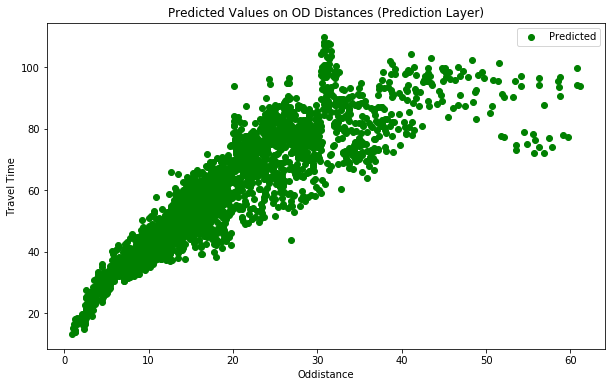

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pred["od_dist"][:3000], y_pred_layer[:3000], color='green', label='Predicted')
plt.title('Predicted Values on OD Distances (Prediction Layer)')
plt.xlabel('Oddistance')
plt.ylabel('Travel Time')
plt.legend()
plt.show()

Append the prediction result back to the prediction layer

In [115]:
tt_df = pd.DataFrame(y_pred_layer, columns = ["traveltime"])

In [116]:
X_pred = X_pred.reset_index(drop= True)

In [117]:
final_dataset = pd.concat([X_pred, tt_df], axis= 1)
final_dataset

,lat_d,lon_d,lat_o,lon_o,od_dist,congested,traveltime
0,19.436474,-99.132744,19.433231,-99.136597,1.308391,0.05,18.086458
1,19.436481,-99.160004,19.433231,-99.136597,2.871368,0.05,25.150288
2,19.447878,-99.136711,19.433231,-99.136597,1.923555,0.05,18.711672
3,19.438856,-99.116585,19.433231,-99.136597,2.610926,0.05,20.515169
4,19.443163,-99.103951,19.433231,-99.136597,3.723792,0.05,26.050461
...,...,...,...,...,...,...,...
5016451,19.236053,-98.822258,19.286211,-98.958275,15.419231,0.40,47.563290
5016452,19.185570,-98.876251,19.286211,-98.958275,14.467017,0.40,48.028416
5016453,19.185570,-98.876251,19.286211,-98.958275,14.467017,0.40,48.028416
5016454,19.037077,-98.788490,19.286211,-98.958275,33.304141,0.40,75.544884


Calculate the Average speed in each row of the prediction layer

In [124]:
final_dataset["Avg Speed"] = final_dataset["od_dist"] / final_dataset["traveltime"]
congested_dataset = final_dataset[final_dataset["congested"] == 0.4]
uncongested_dataset= final_dataset[final_dataset["congested"] == 0.05]

(Optional:) 
sort the dataframes by the ascending order of the oddistances

In [125]:
congested_dataset_sort_by_oddist = congested_dataset.sort_values(by = "od_dist")
congested_dataset_sort_by_oddist

,lat_d,lon_d,lat_o,lon_o,od_dist,congested,traveltime,Avg Speed
3505770,19.327242,-99.325752,19.328905,-99.326607,0.607278,0.4,38.743187,0.015674
2588961,19.327242,-99.325752,19.328905,-99.326607,0.607278,0.4,38.743187,0.015674
3505771,19.327242,-99.325752,19.328905,-99.326607,0.607278,0.4,38.743187,0.015674
4585093,19.457750,-99.278114,19.458908,-99.281021,0.630184,0.4,41.361526,0.015236
3128622,19.457750,-99.278114,19.458908,-99.281021,0.630184,0.4,41.361526,0.015236
...,...,...,...,...,...,...,...,...
2949618,19.058277,-98.790215,19.982527,-99.172905,110.012748,0.4,65.452866,1.680793
4227085,19.058277,-98.790215,19.982527,-99.172905,110.012748,0.4,65.452866,1.680793
3079820,19.902699,-99.093048,18.958742,-98.749924,110.671125,0.4,95.534081,1.158447
4487489,19.902699,-99.093048,18.958742,-98.749924,110.671125,0.4,95.534081,1.158447


In [126]:
uncongested_dataset_sort_by_oddist = uncongested_dataset.sort_values(by = "od_dist")
uncongested_dataset_sort_by_oddist

,lat_d,lon_d,lat_o,lon_o,od_dist,congested,traveltime,Avg Speed
997542,19.327242,-99.325752,19.328905,-99.326607,0.607278,0.05,26.757284,0.022696
80733,19.327242,-99.325752,19.328905,-99.326607,0.607278,0.05,26.757284,0.022696
997543,19.327242,-99.325752,19.328905,-99.326607,0.607278,0.05,26.757284,0.022696
2076865,19.457750,-99.278114,19.458908,-99.281021,0.630184,0.05,33.825577,0.018630
620394,19.457750,-99.278114,19.458908,-99.281021,0.630184,0.05,33.825577,0.018630
...,...,...,...,...,...,...,...,...
441390,19.058277,-98.790215,19.982527,-99.172905,110.012748,0.05,59.141846,1.860151
1718857,19.058277,-98.790215,19.982527,-99.172905,110.012748,0.05,59.141846,1.860151
571592,19.902699,-99.093048,18.958742,-98.749924,110.671125,0.05,94.505463,1.171055
1979261,19.902699,-99.093048,18.958742,-98.749924,110.671125,0.05,94.505463,1.171055


Inspect the value of the average speed in both scenarios 

In [127]:
congested_dataset.describe()["Avg Speed"]["mean"]

0.36178837406774045

In [128]:
uncongested_dataset.describe()["Avg Speed"]["mean"]

0.3675454118117524

Now we plot the Average Speed Congestion vs Uncongestion

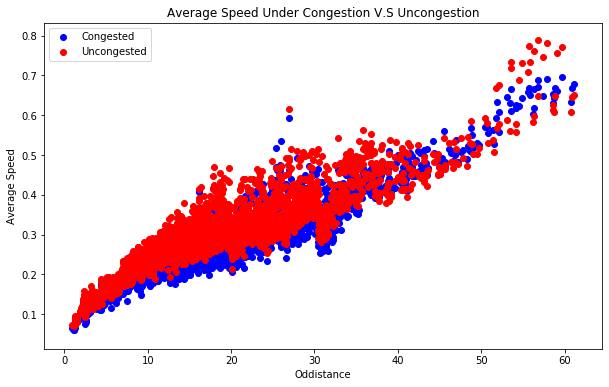

In [129]:
plt.figure(figsize=(10, 6))
plt.scatter(congested_dataset["od_dist"][:3000], congested_dataset["Avg Speed"][:3000], color='blue', label='Congested')
plt.scatter(uncongested_dataset["od_dist"][:3000], uncongested_dataset["Avg Speed"][:3000], color='red', label='Uncongested')
plt.title('Average Speed Under Congestion V.S Uncongestion')
plt.xlabel('Oddistance')
plt.ylabel('Average Speed')
plt.legend()
plt.show()